# Paper Figures

William Colgan May 9 2023

### Setup

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score 
import seaborn as sns

### Load data

In [134]:
df = pd.read_csv("./data/Gaicomelli_Table_3.csv")
df = df[df['AA_wt'] != 'Z']
df = df[df['AA_variant'] != 'Z']
df['A549_Etoposide_Zscore'] = - df['A549_Etoposide_Zscore']
df['Domain'] = df['Domain'].fillna("")
y = df[['A549_Nutlin3_Zscore', 'A549_Etoposide_Zscore']].mean(axis=1).values
df['y'] = y
X = np.load("./data/t33_650M_TP53_Embeddings.npy")

### Figure 1: ESM TSNE

In [ ]:
# get PCA of embeddings
X_pca = PCA(n_components=50).fit_transform(X)
# get TSNE of embeddings
X_tsne = TSNE(n_components=2, perplexity=50, random_state=0).fit_transform(X_pca)

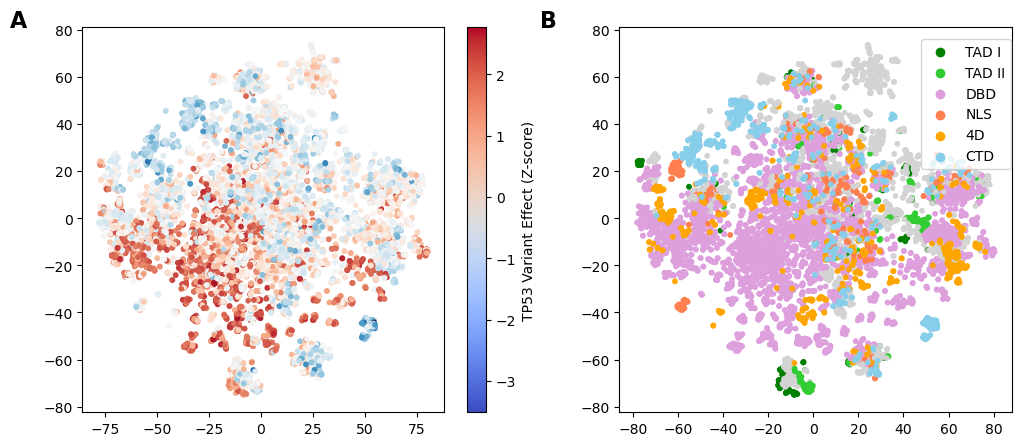

In [288]:
# specify domain colors
domain_colors = {'':'lightgray', 'TAD I':'green', 'TAD II':'limegreen', 'DBD':'plum', \
                  'NLS':'coral', '4D':'orange','CTD':'skyblue'}
# side by side TSNE plots colored by y and domain
fig, ax = plt.subplots(1, 2, figsize=(12, 5),width_ratios = [1.15,1])
ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap = plt.colormaps['RdBu_r'], s=10)
ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Domain'].map(domain_colors), s=10)
# add colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=y.min(), vmax=y.max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label("TP53 Variant Effect (Z-score)")
# add legend
for domain, color in domain_colors.items():
    ax[1].scatter([], [], c=color, label=domain)
ax[1].legend(loc='center left', bbox_to_anchor=(.75, 0.80))
# add A and B labels
ax[0].text(-0.2, 1.0, "A", transform=ax[0].transAxes, size=16, weight='bold')
ax[1].text(-0.2, 1.0, "B", transform=ax[1].transAxes, size=16, weight='bold')
plt.savefig("./figures/embedding_tsne.png", dpi=300,bbox_inches="tight")
plt.show()

# Figure 2: Prediction Scatter

In [135]:
# Split data into 5 folds using sklearn
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(KNeighborsRegressor(n_neighbors=5,algorithm="ball_tree",leaf_size=15,weights="distance",metric='minkowski'), X, y, cv=kf)

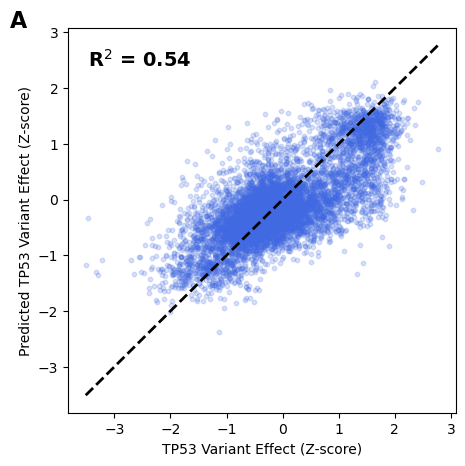

In [286]:
#plot predictions vs true values and add R^2
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(y, y_pred, s=10,color = "royalblue",alpha = .2)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.text(0.05, 0.90, "R$^2$ = %.2f" % r2_score(y, y_pred), transform=ax.transAxes, size=14, weight='bold')
ax.set_xlabel("TP53 Variant Effect (Z-score)")
ax.set_ylabel("Predicted TP53 Variant Effect (Z-score)")
# add A label
ax.text(-0.15, 1.0, "A", transform=ax.transAxes, size=16, weight='bold')
plt.savefig("./figures/pred_vs_true.png", dpi=300, bbox_inches="tight")
plt.show()

### Figure 3: Prediction Heatmap

In [161]:
df['y_pred'] = y_pred
df['residual'] = np.abs(df['y'] - df['y_pred'])

# pivot df long to wide by Position and AA_wt
pred_wide = df.pivot_table(index=['Position', 'AA_wt'], columns='AA_variant', values='y_pred').reset_index()
pred_wide = pred_wide.drop(columns=['B'])

# pivot df long to wide by Position and AA_wt
resid_wide = df.pivot_table(index=['Position', 'AA_wt'], columns='AA_variant', values='residual').reset_index()
resid_wide = resid_wide.drop(columns=['B'])


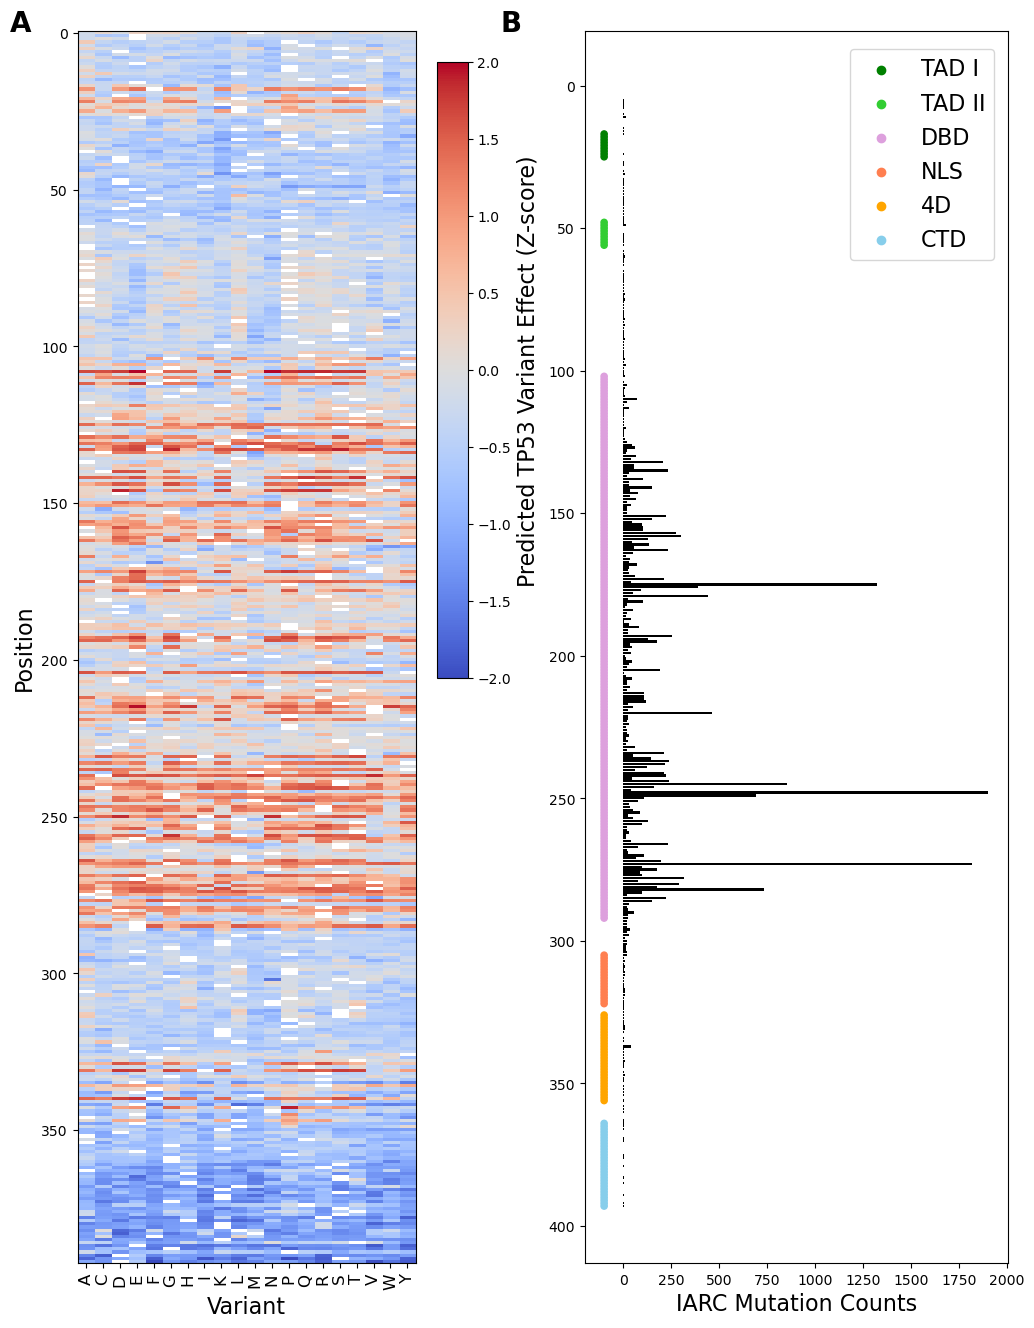

In [287]:
fig, ax = plt.subplots(1, 2, figsize=(12,16),width_ratios = [1,1])
ax[0].imshow(pred_wide.drop(columns=['Position', 'AA_wt']).values, cmap='coolwarm', vmin=-2, vmax=2,aspect='auto')

# label x axis with AA_variant
ax[0].set_xticks(np.arange(len(pred_wide.columns)-2))
ax[0].set_xticklabels(pred_wide.drop(columns=['Position', 'AA_wt']).columns, rotation=90,size=12)
ax[0].set_xlabel("Variant",size=16)
# label y axis with Position
ax[0].set_ylabel("Position",size=16)
# add colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-2, vmax=2))
sm._A = []
cbar = fig.colorbar(sm, ax=ax[0],shrink=0.5,anchor = (0,.95))
cbar.set_label("Predicted TP53 Variant Effect (Z-score)",size = 16)
# make colorbar smaller

ax[1].barh(iarc['Position'],iarc['IARC_Mutation_Counts'], color='black')
ax[1].scatter(iarc[iarc['Domain'] != ""]['loc'],iarc[iarc['Domain'] != ""]['Position'], c=iarc[iarc['Domain'] != ""]['Domain'].map(domain_colors), s=20)
#ax[1].set_ylabel("Position",size=16)
ax[1].set_xlabel("IARC Mutation Counts",size=16)
# flip y axis
ax[1].set_ylim(ax[1].get_ylim()[::-1])

# add legend
for domain, color in domain_colors.items():
    ax[1].scatter([], [], c=color, label=domain)
ax[1].legend(loc='center left', bbox_to_anchor=(.6, 0.90),fontsize="16")

# add A and B labels
ax[0].text(-0.2, 1.0, "A", transform=ax[0].transAxes, size=20, weight='bold')
ax[1].text(-0.2, 1.0, "B", transform=ax[1].transAxes, size=20, weight='bold')
plt.savefig("./figures/pred_and_resid_heatmaps.png", dpi=300,bbox_inches="tight")
plt.show()

### Figure 4: Prediction vs ClinVar Annotation

In [270]:
clinvar = pd.read_csv("./data/Clinvar_TP53.csv")
clinvar = clinvar[clinvar['Gene(s)'] == "TP53"]
# filter protein change not NaN
clinvar = clinvar[clinvar['Protein change'].notnull()]
clinvar['significance'] = clinvar['Clinical significance (Last reviewed)'].str.split("(").str[0]
#split protein change into multiple rows
clinvar = clinvar.assign(Protein_change=clinvar['Protein change'].str.split(", ")).explode('Protein_change')

In [267]:
# filter significance not NaN
test = df_clivar[df_clivar['significance'].notnull()]

In [271]:
# left join df and clinvar on Allele and Protein change
df_clivar = df.merge(clinvar, how='left', left_on=['Allele'], right_on=['Protein_change'])

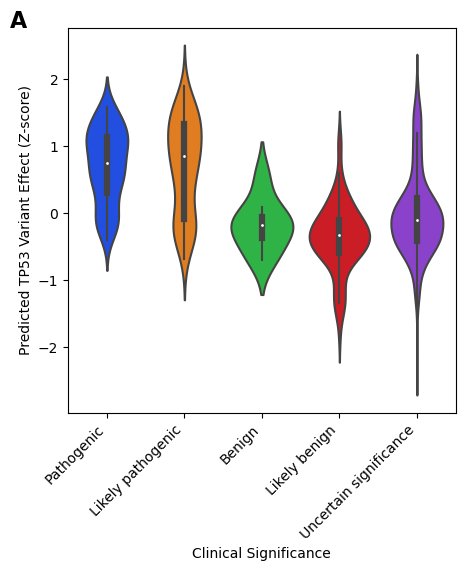

In [285]:
# y_pred violin by Clinical significance using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.violinplot(x="significance", y="y_pred", data=df_clivar, ax=ax, order=['Pathogenic', 'Likely pathogenic', 'Benign', \
    'Likely benign', 'Uncertain significance'],palette = sns.color_palette("bright"))
# add A label
ax.text(-0.15, 1.0, "A", transform=ax.transAxes, size=16, weight='bold')
ax.set_xlabel("Clinical Significance")
ax.set_ylabel("Predicted TP53 Variant Effect (Z-score)")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",)
plt.savefig("./figures/pred_vs_clinvar.png", dpi=300, bbox_inches="tight")
plt.show()